In [1]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
VALID_IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"] # valid extensions

def load_image(infilename):
    img = Image.open(infilename)
    img = img.resize((80,80))
    data = np.asarray(img)
    return data


    
def save_image(np_array, output_filename) :
    im = Image.fromarray(np_array, "RGB")
    im.save(output_filename)     
    
def map_images(data_dir, verbose = False):
    files = {}
    CLASSES = {}

    for class_id, class_dir in enumerate(os.listdir(data_dir)):
        class_name = class_dir
        class_dir = os.path.join(data_dir, class_dir)
        files[class_id] = []
        CLASSES[class_id] = class_name
        for file in os.listdir(class_dir):

            ext = os.path.splitext(file)[1]
            if ext in VALID_IMAGE_EXTENSIONS:

                np_im = load_image(os.path.join(class_dir,file))
                files[class_id].append(np_im)
#                 save_image(np_im,"i.jpg")
        if verbose:
            print(f"Done: {class_dir}")
    return CLASSES, files

# https://www.kaggle.com/prasunroy/natural-images
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)

In [3]:
def init_users_image(files,  averaging_metric="accuracy", test_size = 0.2, val_size = 0.2, shape=(80,80,3), seed=None):
    users = {}
    keys = list(files.keys())
    
    # initialise users
    for class_id in keys:
        model = init_conv_model(keys, shape, seed)
#         model = init_model()

        option = np.random.RandomState(seed).randint(0,len(averaging_methods))
        users[class_id] = User(user_id=class_id,
                  model = model,
                  averaging_method = averaging_methods[option],
                  averaging_metric = averaging_metric,
                  train_class = None,
                  train_data = None,
                  val_class = None,
                  val_data = None, 
                  test_class = None,
                  test_data = None)
    
    # for class ids in keys, we will now create a majority and rest (of the data) split
    
    for class_id in keys:
        images = np.asarray(files[class_id]).astype("float32")
        # shuffle first pls
        majority_data, rest_data = np.split(images, [int(0.7 * len(images))])
        rest_data_split = np.array_split(rest_data,len(keys)-1)  
        
        rest_data_index = 0
        for user_id in keys:
            if user_id == class_id:
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(majority_data, class_id, test_size, val_size)
            else:
                raw_data = rest_data_split[rest_data_index]
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(raw_data, class_id, test_size, val_size)
                rest_data_index += 1
                
            if class_id == 0:
                users[user_id].set_test_class(test_class)
                users[user_id].set_test_data(test_data)
                users[user_id].set_val_data(val_data)
                users[user_id].set_val_class(val_class)
                users[user_id].set_train_data(train_data)
                users[user_id].set_train_class(train_class)
            else:
                users[user_id].add_test_class(test_class)
                users[user_id].add_test_data(test_data)
                users[user_id].add_val_data(val_data)
                users[user_id].add_val_class(val_class)
                users[user_id].add_train_data(train_data)
                users[user_id].add_train_class(train_class)
    return users

def train_test_val_split(np_data, class_id, test_size, val_size):
    test_data, train_data = np.split(np_data, [int(test_size * len(np_data))])
    val_size = val_size/(1-test_size)
    val_data, test_data = np.split(test_data, [int(val_size * len(test_data))])
    
    train_class = np.full((train_data.shape[0]),class_id)
    test_class = np.full((test_data.shape[0]),class_id)
    val_class = np.full((val_data.shape[0]),class_id)
#     print(f"              {val_class.shape[0] == val_data.shape[0]}")
    return train_data, train_class, test_data, test_class, val_data, val_class
        
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
      

#     global_user = User()

In [4]:
DEVICE = '/gpu:0'
ROUNDS = 20
EPOCHS = 20

In [5]:
# forces tensorfor to the a particular device to run things
with tf.device(DEVICE):
#     averaging_methods = [Average.all]
#      # return a dictionary of users with data
    users_all = init_users_image(files, seed = SEED)
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
#     users_all_2, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                         seed = SEED)
#     train_fed(users = users_all_2, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
#      print(len(users_all[2].get_history_metrics()["sparse_categorical_accuracy"]))
#     draw_graphs(users_all[2])   



********************************  0   ********************************
0 [68.83594796715713, 0.05691057]
1 [13.412223618606042, 0.0862069]
2 [36.22641944885254, 0.046875]
3 [16.14833810143437, 0.4680851]
4 [26.402294158935547, 0.05263158]
5 [18.63197390238444, 0.4652778]
6 [38.122082503525526, 0.055944055]
7 [29.04360476407138, 0.053030305]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.08447555797856, 0.048780486]
1 [2.0768745685445853, 0.05172414]
2 [2.074927508831024, 0.046875]
3 [2.107923093417012, 0.04255319]
4 [2.0814967197284364, 0.05263158]
5 [2.0916485521528454, 0.041666668]
6 [2.0307424101796183, 0.72727275]
7 [2.090451298337994, 0.045454547]
******************************** DONE ********************************
********************************  2   ********************************
0 [2.098771670969521, 0.048780486]
1 [2.1090713533861885, 0.05172414]
2 [2.0494996905326843, 0.04

All
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       19
Average               0.621451
Standard Deviation    0.190986
Minimum               0.315789
Maximum               0.895833
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        19
Average                0.786981
Standard Deviation    0.0729017
Minimum                0.657895
Maximum                0.916667
Name: 39, dtype: object



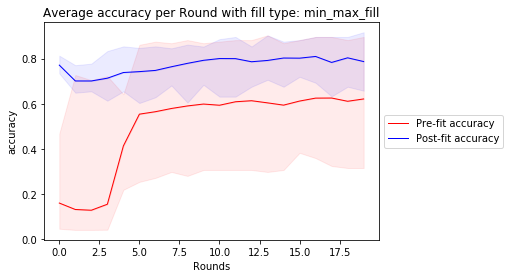

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.788618
3     1     0.681035
5     2     0.414062
7     3     0.695035
9     4     0.315789
11    5     0.895833
13    6     0.734266
15    7     0.446970
Averaged: 0.6214510723948479

Final accuracy for Post-fit data
   User  Final Value
0     0     0.837398
2     1     0.732759
4     2     0.742188
6     3     0.822695
8     4     0.657895
10    5     0.916667
12    6     0.783217
14    7     0.803030
Averaged: 0.786981001496315



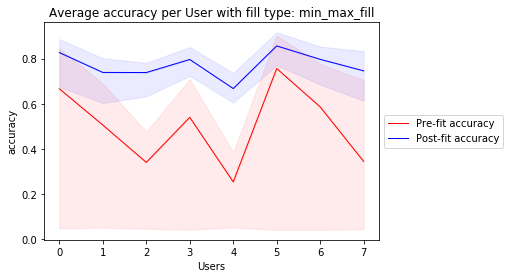

<Figure size 432x288 with 0 Axes>

In [6]:
ignore_first_n = 0
final_values = True

GRAPHING_METRIC = "accuracy"


print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_2, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_2, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

In [7]:
%reset_selective -f "^users_*"

with tf.device(DEVICE):
    averaging_methods = [Average.std_dev]
    # return a dictionary of users with data
    users_std_dev = init_users_image(files)
    train_fed(users = users_std_dev, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method =  Average.std_dev,
             averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_std_dev_2 = init_users_image(files)
    train_fed(users = users_std_dev_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    

********************************  0   ********************************
0 [26.595997771596522, 0.032520324]
1 [32.58050602880017, 0.060344826]
2 [17.14215612411499, 0.0703125]
3 [42.525009263491796, 0.056737587]
4 [8.754799273976108, 0.14035088]
5 [53.16436915927463, 0.041666668]
6 [17.329963724096338, 0.15384616]
7 [54.19307315710819, 0.03787879]
User 4: 0.7280701994895935 < 0.7430837129932721
User 6: 0.7272727489471436 < 0.7430837129932721
******************************** DONE ********************************
********************************  1   ********************************
0 [2.087698449933432, 0.040650405]
1 [2.042591588250522, 0.6465517]
2 [2.097554564476013, 0.0390625]
3 [2.075889731129856, 0.035460994]
4 [2.1006693003470436, 0.04385965]
5 [2.050688876046075, 0.125]
6 [2.101446770287894, 0.034965035]
7 [2.085975256833163, 0.03787879]
User 4: 0.5526315569877625 < 0.628813660450011
******************************** DONE ********************************
**************************

Std deviation
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       19
Average               0.583144
Standard Deviation    0.197075
Minimum               0.280702
Maximum               0.861111
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        19
Average                0.795676
Standard Deviation    0.0708443
Minimum                0.689655
Maximum                0.878049
Name: 39, dtype: object



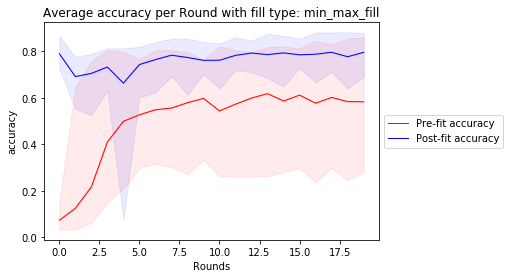

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.845528
3     1     0.603448
5     2     0.390625
7     3     0.595745
9     4     0.280702
11    5     0.861111
13    6     0.671329
15    7     0.416667
Averaged: 0.5831443257629871

Final accuracy for Post-fit data
   User  Final Value
0     0     0.878049
2     1     0.689655
4     2     0.781250
6     3     0.815603
8     4     0.692982
10    5     0.875000
12    6     0.860140
14    7     0.772727
Averaged: 0.7956757918000221



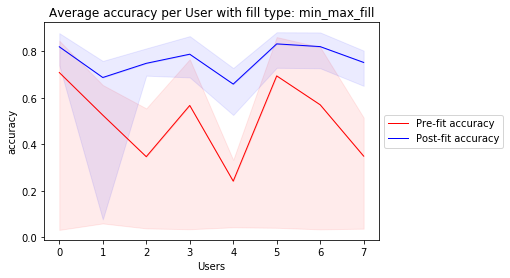

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       19
Average               0.677205
Standard Deviation    0.200714
Minimum               0.280702
Maximum               0.861111
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        19
Average                0.812635
Standard Deviation    0.0465483
Minimum                0.736842
Maximum                0.868056
Name: 39, dtype: object



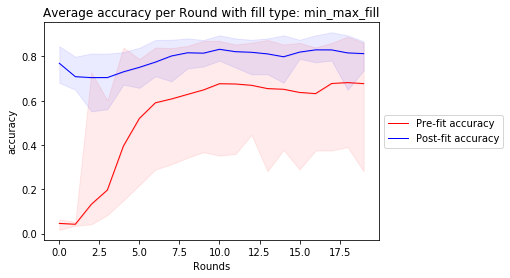

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.853659
3     1     0.715517
5     2     0.468750
7     3     0.801418
9     4     0.280702
11    5     0.861111
13    6     0.853147
15    7     0.583333
Averaged: 0.6772046536207199

Final accuracy for Post-fit data
   User  Final Value
0     0     0.861789
2     1     0.775862
4     2     0.773438
6     3     0.851064
8     4     0.736842
10    5     0.868056
12    6     0.846154
14    7     0.787879
Averaged: 0.8126353025436401



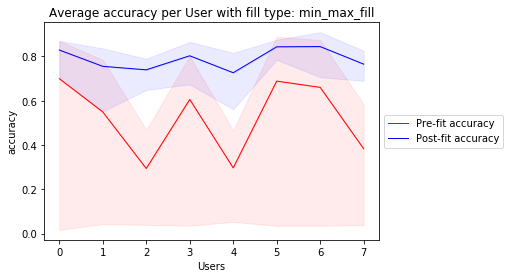

<Figure size 432x288 with 0 Axes>

In [8]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Std deviation")
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


# print(users_std_dev[1].get_history_metrics())


In [5]:
%reset_selective -f "^users_*"

with tf.device(DEVICE):
    averaging_methods = [Average.weighted_avg]
    
    # return a dictionary of users with data
    users_weighted_avg = init_users_image(files)
    train_fed(users = users_weighted_avg, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.weighted_avg,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_weighted_avg_2 = init_users_image(files)
    train_fed(users = users_weighted_avg_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")

********************************  0   ********************************
0 [43.95520438217535, 0.048780486]
1 [22.40466440135035, 0.06896552]
2 [24.977935791015625, 0.03125]
3 [46.25712358867023, 0.04964539]
4 [24.408507296913548, 0.05263158]
5 [35.441627502441406, 0.034722224]
6 [11.120228620675894, 0.20979021]
7 [41.967136614250414, 0.030303031]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.103454392130782, 0.048780486]
1 [2.0879147792684623, 0.05172414]
2 [2.0753400325775146, 0.046875]
3 [2.131679935658232, 0.04255319]
4 [2.0625949198739573, 0.05263158]
5 [2.0846615632375083, 0.041666668]
6 [2.0913975922377794, 0.04195804]
7 [2.009640704501759, 0.70454544]
******************************** DONE ********************************
********************************  2   ********************************
0 [2.1275330345805097, 0.048780486]
1 [2.0823570777629983, 0.05172414]
2 [2.092592060565948

Weighted average
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       19
Average               0.596836
Standard Deviation    0.215427
Minimum                 0.3125
Maximum               0.854167
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        19
Average                0.796256
Standard Deviation    0.0392133
Minimum                0.726562
Maximum                0.847222
Name: 39, dtype: object



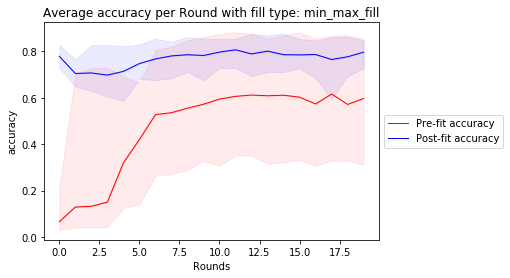

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.821138
3     1     0.655172
5     2     0.312500
7     3     0.709220
9     4     0.333333
11    5     0.854167
13    6     0.748252
15    7     0.340909
Averaged: 0.5968364179134369

Final accuracy for Post-fit data
   User  Final Value
0     0     0.829268
2     1     0.775862
4     2     0.726562
6     3     0.808511
8     4     0.763158
10    5     0.847222
12    6     0.839161
14    7     0.780303
Averaged: 0.7962559387087822



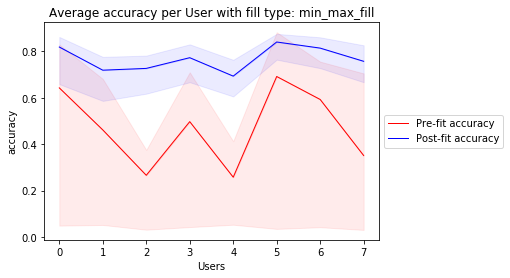

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       19
Average               0.631476
Standard Deviation    0.147387
Minimum               0.421053
Maximum               0.868056
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       19
Average               0.703305
Standard Deviation    0.233973
Minimum               0.103448
Maximum               0.868056
Name: 39, dtype: object



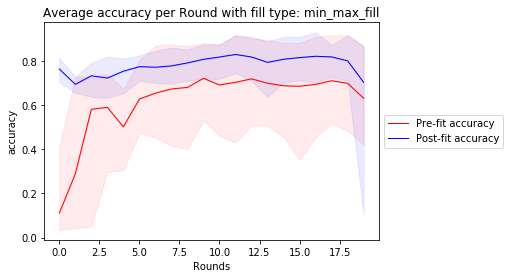

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.772358
3     1     0.612069
5     2     0.437500
7     3     0.723404
9     4     0.421053
11    5     0.868056
13    6     0.664336
15    7     0.553030
Averaged: 0.6314756348729134

Final accuracy for Post-fit data
   User  Final Value
0     0     0.829268
2     1     0.103448
4     2     0.796875
6     3     0.723404
8     4     0.675439
10    5     0.868056
12    6     0.804196
14    7     0.825758
Averaged: 0.7033054167404771



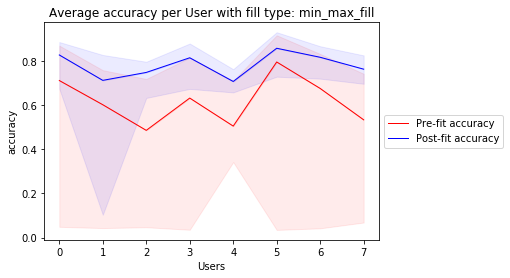

<Figure size 432x288 with 0 Axes>

In [6]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Weighted average")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


In [5]:
%reset_selective -f "^users_*"

with tf.device(DEVICE):
    users_local_only = init_users_image(files)
    train_fed(users = users_local_only, rounds = ROUNDS,
              epochs = EPOCHS,
              
              strat = "local_trainings_only",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
        
#     print("Global user training and validation")

#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

********************************  0   ********************************
0 [24.536138348463105, 0.040650405]
1 [21.842859202417834, 0.06896552]
2 [31.750483989715576, 0.0546875]
3 [7.53516305422952, 0.44680852]
4 [23.018987605446263, 0.03508772]
5 [32.34979544745551, 0.034722224]
6 [32.7022808181656, 0.04895105]
7 [15.831934148615057, 0.07575758]
******************************** DONE ********************************
********************************  1   ********************************
0 [0.5619663674293495, 0.8455285]
1 [2.1002639244342673, 0.6896552]
2 [2.5485999807715416, 0.7578125]
3 [1.0340471242336517, 0.78014183]
4 [4.782450491921944, 0.6403509]
5 [1.9114637195127275, 0.8402778]
6 [1.9894582000854133, 0.8041958]
7 [2.3744337775490503, 0.72727275]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.6665605729279237, 0.85365856]
1 [5.218050397675613, 0.7241379]
2 [3.5232021510601044, 0.796

Local training only
Final values for Pre-fit accuracy
Position                    Pre
Round                        19
Average                0.725658
Standard Deviation    0.0937009
Minimum                     0.5
Maximum                0.826389
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        19
Average                0.731091
Standard Deviation    0.0724164
Minimum                0.578947
Maximum                0.819444
Name: 39, dtype: object



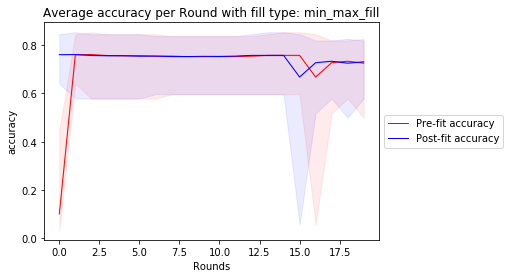

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.715447
3     1     0.724138
5     2     0.718750
7     3     0.751773
9     4     0.500000
11    5     0.826389
13    6     0.811189
15    7     0.757576
Averaged: 0.725657694041729

Final accuracy for Post-fit data
   User  Final Value
0     0     0.747967
2     1     0.724138
4     2     0.671875
6     3     0.737589
8     4     0.578947
10    5     0.819444
12    6     0.811189
14    7     0.757576
Averaged: 0.731090672314167



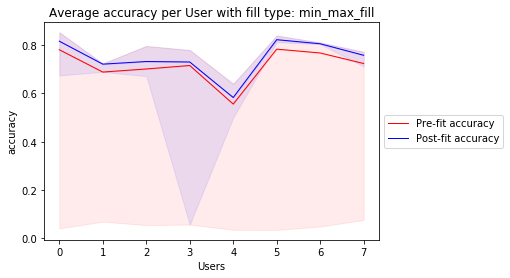

<Figure size 432x288 with 0 Axes>

In [7]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"


print("Local training only")


df_avg_round_stats_acc = avg_round_stats(users_local_only, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_local_only, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
# draw_graphs(users_all_2[2])

# print("Global user")
# draw_graphs(global_user)
# global_user.evaluate(verbose=False)

In [ ]:
for user in users_std_dev_2.values():
    draw_graphs(user)